📊 Dataset Parameters:
Mean Temp: 20.30, Std Temp: 0.63
Mean Humidity: 55.24, Std Humidity: 5.18
λ (Rain Events): 5.36, p (Storm): 0.10

✅ Sample Transition Probabilities:
Partially cloudy: {'Partially cloudy': 0.33, 'Clear': 0.67}
Clear: {'Partially cloudy': 0.18, 'Clear': 0.82}

🌦 Simulated Weather Data (First 10 Days):
         Date  Day         Condition  Temperature (°C)  Humidity (%)  \
0  2025-11-09    1  Partially cloudy             20.61         54.52   
1  2025-11-10    2  Partially cloudy             21.29         59.22   
2  2025-11-11    3             Clear             19.94         50.45   
3  2025-11-12    4             Clear             21.22         54.07   
4  2025-11-13    5  Partially cloudy             19.92         60.15   
5  2025-11-14    6             Clear             20.81         48.92   
6  2025-11-15    7             Clear             20.23         53.68   
7  2025-11-16    8  Partially cloudy             19.88         58.41   
8  2025-11-17    9           

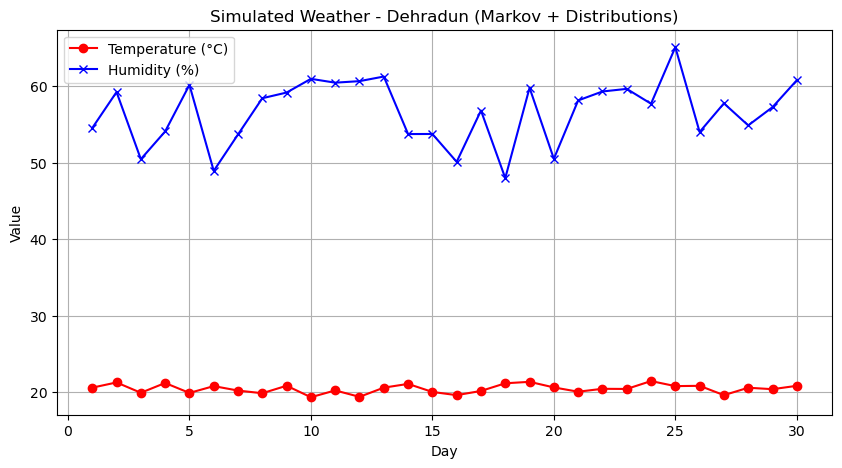

In [4]:
# -----------------------------
# main_system_integration.ipynb
# -----------------------------
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime as dt

# -----------------------------
# Step 1: Load and preprocess dataset
# -----------------------------
df = pd.read_csv("dehradun_weather_processed.csv")
df.columns = df.columns.str.strip()

# Extract features
conditions = df["condition_text"].tolist()
temperature = df["temperature_celsius"]
humidity = df["humidity"]
wind_speed = df["wind_kph"]

# -----------------------------
# Step 2: Compute statistical parameters
# -----------------------------
mean_temp = temperature.mean()
std_temp = temperature.std()

mean_hum = humidity.mean()
std_hum = humidity.std()

# Poisson λ for rain events (linked with wind speed intensity)
lambda_rain = max(0.5, wind_speed.mean())

# Binomial probability for thunderstorm events
p_storm = (df["condition_text"].str.contains("Storm|Thunder", case=False)).mean() or 0.1

print("📊 Dataset Parameters:")
print(f"Mean Temp: {mean_temp:.2f}, Std Temp: {std_temp:.2f}")
print(f"Mean Humidity: {mean_hum:.2f}, Std Humidity: {std_hum:.2f}")
print(f"λ (Rain Events): {lambda_rain:.2f}, p (Storm): {p_storm:.2f}")

# -----------------------------
# Step 3: Build Markov Transition Matrix
# -----------------------------
states = list(set(conditions))
transition_counts = {s: {s2: 0 for s2 in states} for s in states}

# Count transitions between consecutive days
for today, tomorrow in zip(conditions[:-1], conditions[1:]):
    transition_counts[today][tomorrow] += 1

# Convert counts to probabilities
transition_matrix = {}
for s in states:
    total = sum(transition_counts[s].values())
    transition_matrix[s] = {
        s2: round(transition_counts[s][s2] / total, 2) if total > 0 else 0
        for s2 in states
    }

print("\n✅ Sample Transition Probabilities:")
for s in list(transition_matrix.keys())[:3]:
    print(f"{s}: {transition_matrix[s]}")

# -----------------------------
# Step 4: Initialize simulation
# -----------------------------
num_days = 30
weather_data = []

# Start simulation from last date in dataset
start_date = pd.to_datetime(df["date"].iloc[-1]) + pd.Timedelta(days=1)
dates = [(start_date + pd.Timedelta(days=i)).strftime("%Y-%m-%d") for i in range(num_days)]

current_state = random.choice(states)
np.random.seed(42)

# -----------------------------
# Step 5: Simulate weather day by day
# -----------------------------
for day in range(num_days):
    temp = np.random.normal(mean_temp, std_temp)
    hum = np.random.normal(mean_hum, std_hum)
    rain = np.random.poisson(lambda_rain)
    thunder = np.random.binomial(1, p_storm)

    weather_data.append({
        "Date": dates[day],
        "Day": day + 1,
        "Condition": current_state,
        "Temperature (°C)": round(temp, 2),
        "Humidity (%)": round(hum, 2),
        "Rainfall (events)": rain,
        "Thunderstorm": bool(thunder)
    })

    # Transition to next state using Markov chain
    next_states = list(transition_matrix[current_state].keys())
    probs = list(transition_matrix[current_state].values())
    current_state = random.choices(next_states, weights=probs, k=1)[0]

# -----------------------------
# Step 6: Display and visualize simulated results
# -----------------------------
sim_df = pd.DataFrame(weather_data)
print("\n🌦 Simulated Weather Data (First 10 Days):")
print(sim_df.head(10))

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(sim_df["Day"], sim_df["Temperature (°C)"], label="Temperature (°C)", color="red", marker='o')
plt.plot(sim_df["Day"], sim_df["Humidity (%)"], label="Humidity (%)", color="blue", marker='x')
plt.title("Simulated Weather - Dehradun (Markov + Distributions)")
plt.xlabel("Day")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

